November: Part 3 - This notebook is a continuation of gyre_runs.ipynb and gyre_runs_mackenzie01.ipynb. The configuration used to produce these results is gyre_mackenzie02. Parameters explored: ln_tsd_init, ln_tsd_tradmp, sn_tem, sn_sal.

Changes since Part 2:
* matlab scaling factors script has transposed lons and lats so it won't flip the dimensions
* masking land using [Nancy notebook](http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/analysis-nancy/raw/tip/notebooks/Masking%20with%20tmask.ipynb)
* now, we have the realistic bathymetry that matches the idealized bathymetry
* the idealized bathymetry has been refined (slope)
* the stratification based on Arctic data is inputted into the model

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/modules/')
import functions_plot

from salishsea_tools import nc_tools

In [113]:
def plot_gyre_times(gridT, var, depth_ind, time_inds, cmax, cmaps, max_min, supttl):
    cmin = -cmax
    cmaps.set_bad('green')
    fig, ax = plt.subplots(1, len(time_inds), figsize=(20, 4.5), sharex=True, sharey=True)
    for i, n in zip(time_inds, np.arange(len(time_inds))):
        if max_min == True:
            c = ax[n].pcolormesh(var[i,depth_ind,:,:], cmap=cmaps, vmin = cmin, vmax = cmax)
            if n == 0:
                cbar = fig.colorbar(c, ax=ax[0])
        elif max_min == False:
            c = ax[n].pcolormesh(var[i,depth_ind,:,:], cmap=cmaps)
            cbar = fig.colorbar(c, ax=ax[n])
        timestamp = nc_tools.timestamp(gridT,i).format('MMM DD HH:mm')
        ax[n].set_title(timestamp, fontsize=16)
        ax[n].set_xlim(0,gridT.dimensions['x'].size)
        ax[n].set_ylim(0,gridT.dimensions['y'].size)
        ax[n].xaxis.set_visible(False); ax[n].yaxis.set_visible(False)
    title = supttl + ' (' + str(int(gridT['deptht'][depth_ind])) + 'm)'
    fig.tight_layout(); fig.subplots_adjust(top=0.85); fig.suptitle(title, fontsize=20)
    return fig

def plot_vars(gridT, all_vars, depth_ind, time_ind, cmaxs, cmaps, max_min, supttl, ttls):
    cmins = [-x for x in cmaxs]
    cmaps.set_bad('wheat')
    fig, ax = plt.subplots(1, len(all_vars), figsize=(20, 4.5), sharex=True, sharey=True)
    for var, cmin, cmax, n, ttl in zip(all_vars, cmins, cmaxs, np.arange(len(all_vars)), ttls):
        if max_min == True:
            c = ax[n].pcolormesh(var[time_ind,depth_ind,:,:], cmap=cmaps, vmin = cmin, vmax = cmax)
            cbar = fig.colorbar(c, ax=ax[n])
        elif max_min == False:
            c = ax[n].pcolormesh(var[time_ind,depth_ind,:,:], cmap=cmaps)
            cbar = fig.colorbar(c, ax=ax[n])
        timestamp = nc_tools.timestamp(gridT,time_ind).format('HH:mm')
        ax[n].xaxis.set_visible(False); ax[n].yaxis.set_visible(False)
        ax[n].set_title(ttl, fontsize=16)
    title = supttl + ' (' + str(int(gridT['deptht'][depth_ind])) + 'm, ' + timestamp + ')'
    fig.tight_layout(); fig.subplots_adjust(top=0.85); fig.suptitle(title, fontsize=20)
    return fig

## Summary


* cp_cfg name
* bathy_meter.nc and coordinates.nc
* nn_bathy = 1 (0 for compute)
* jphgr_msh = 0 (5 for gyre)
* jperio = 1 (cyclic)
* ln_zco, ln_zps
* jpidta = jpiglo, jpjdta = jpjglo, jpkdta 


|Parameter      |Run01 (Id)|Run01 (Re)|Run08 (Id)|Run09 (Id)|
|---------------|----------|----------|----------|----------|
|cp_cfg         |ideal     |real      |ideal     ||
|ln_bt_nn_auto  |False     |True      |False     ||
|rn_bt_cmax     |NA        |0.05      |NA        ||
|rn_rdt         |20        |10        |20        |8         |
|nn_baro        |4         |NA        |4         ||
|calc nn_baro   |NA        |5         |NA        ||
|nn_itend       |2160 (12h)|4320 (12h)|21600 (5d)|10800(24h)|
|nn_write       |360 (1h)  |---       |1080 (6h) |450 (1h)  |
|nn_tau000 [ts] |540 (3h)  |1080      |4320 (1d) |1350 (3h) |
|rn_utau0 [N/m2]|-5.0      |-5.0      |-5.0      ||
|rn_vtau0 [N/m2]|0         |0         |0         ||
|jperio         |cyclic    |cyclic    |cyclic    |closed|
|status         | ✓        | ✓        |✓        |||

* under these nn_itend and nn_write, the stages where the code can fail are [1, 361, 721, 1081, 1441, 1801]
* from Part 2, remember you have to reduce timestep and then consider the wind forcing
* running longer simulations: cd EXP00 >> ./opa & >> exit >> ps -aux |grep imachu

In [3]:
# calculate nn_baro using rn_rdt and cmax
g = 9.81; cmax = 0.05; dx = 4501; H = 1300; dt_clinic = 10 #(rn_rdt)
u = np.sqrt(g * H)
dt_tropic = (cmax * dx) / u
iterations = dt_clinic / dt_tropic
iterations

5.0179596244528888

# Run01: Idealized vs Realistic

These runs use a configuration similar to the ones that are proven to run from gyre_runs_mackenzie01.ipynb. Both runs try to simulate the same scenario. The realistic needed a smaller timestep so nn_itend and nn_tau were modified to accommodate this change. The original gyre stratification was used.

1. mackenzie_canyon/bathymetry/initial_sets/idealized/**ideal_bathy_01.nc**
2. mackenzie_canyon/bathymetry/initial_sets/realistic/**real_bathy_01.nc**
3. mackenzie_canyon/bathymetry/initial_sets/coordinates/**coords_01.nc**

In [64]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run01'
gridT_I1, lon_I1, lat_I1, tem_I1, sal_I1, ssh_I1, U_I1, V_I1, W_I1 = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_realistic/Run01'
gridT_R1, lon_R1, lat_R1, tem_R1, sal_R1, ssh_R1, U_R1, V_R1, W_R1 = functions_plot.load_model_output(path, cfg)

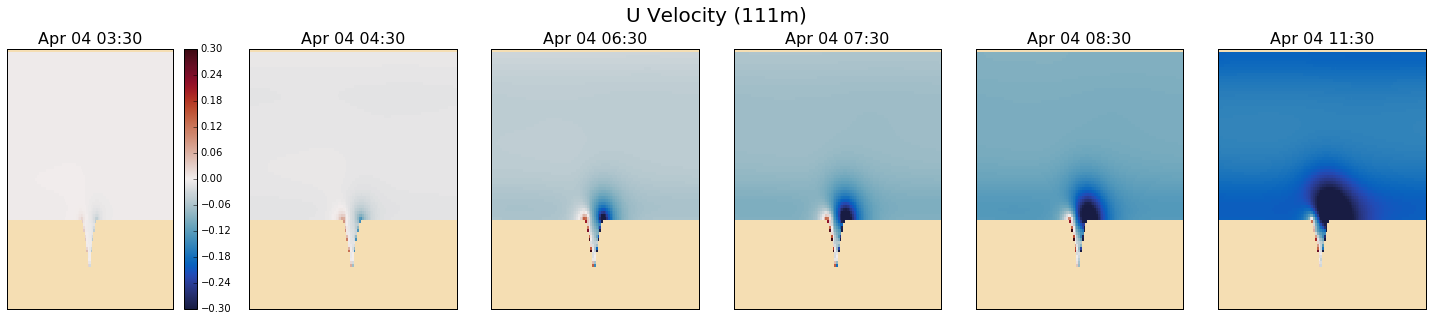

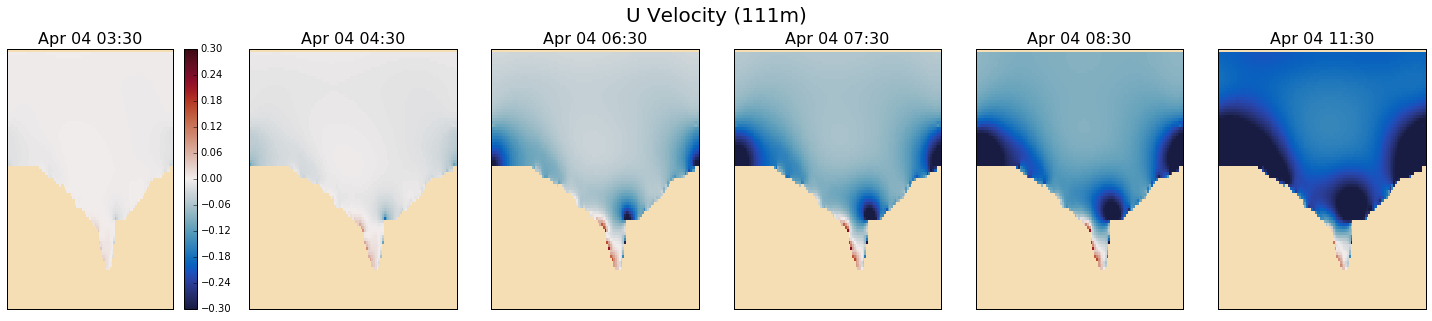

In [68]:
dep = 8
time_inds = [3,4,6,7,8,11]
bd = 0.3
max_min = True
supttl = 'U Velocity'
fig = plot_gyre_times(gridT_I1, U_I1, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)
fig = plot_gyre_times(gridT_R1, U_R1, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)

# Run02: Arctic Stratification

These runs have the **same configurations** as Run01 and still use **ideal_bathy_01.nc**, **real_bathy_01.nc**, and **coords_01.nc**. What's new is that these runs use the temperature and salinity files created in prepare_stratification.ipynb.

1. mackenzie_canyon/conditions/stratification_files/**temp_strat.nc** & **temp_strat_real.nc**
2. mackenzie_canyon/conditions/stratification_files/**salt_strat.nc** & **temp_strat_real.nc**

### Notes
(Pages 67 and 129) In namtsd, **ln_tsd_init** and **ln_tsd_tradmp** are True and **sn_tem** and **sn_sal** are:

| Parameter             | Description | Values|
|-----------------------|-------------|-------|
| File name             |can include directory, doesn't have to have .nc| 'temp_strat', 'salt_strat'|
| Record frequency      |contained in input file, +ive if hours, -ive if months, integer| 1|
| Variable name         |'votemper', 'vosaline'| 'votemper', 'vosaline'|
| Time interpolation    |false if forcing remains constant during each forcing period| false|
| Climatological forcing|true if input file contains climatological forcing which can be cycled in time| true|
| Open/close frequency  |forcing files have data from the beginning of one 'daily','weekLLL','monthly','yearly'| 'yearly'|


In [14]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run02'
gridT_I2, lon_I2, lat_I2, tem_I2, sal_I2, ssh_I2, U_I2, V_I2, W_I2 = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_realistic/Run02'
gridT_R2, lon_R2, lat_R2, tem_R2, sal_R2, ssh_R2, U_R2, V_R2, W_R2 = functions_plot.load_model_output(path, cfg)

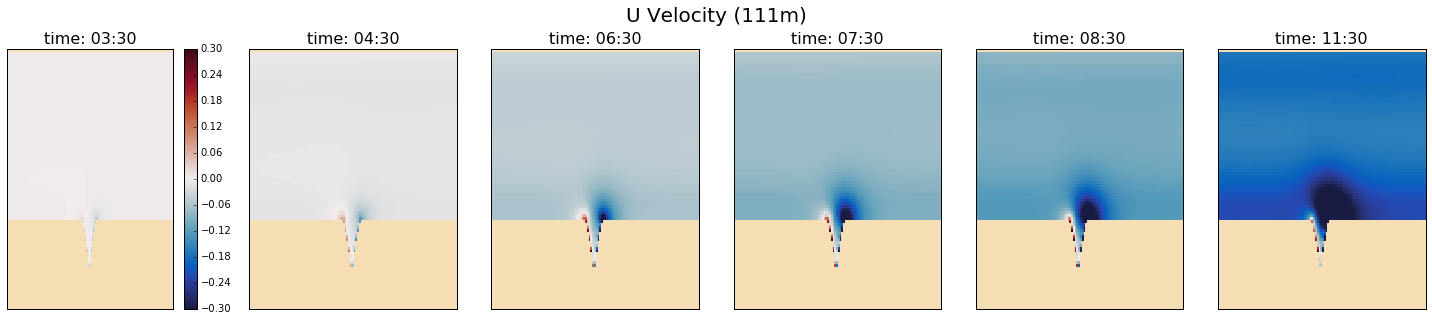

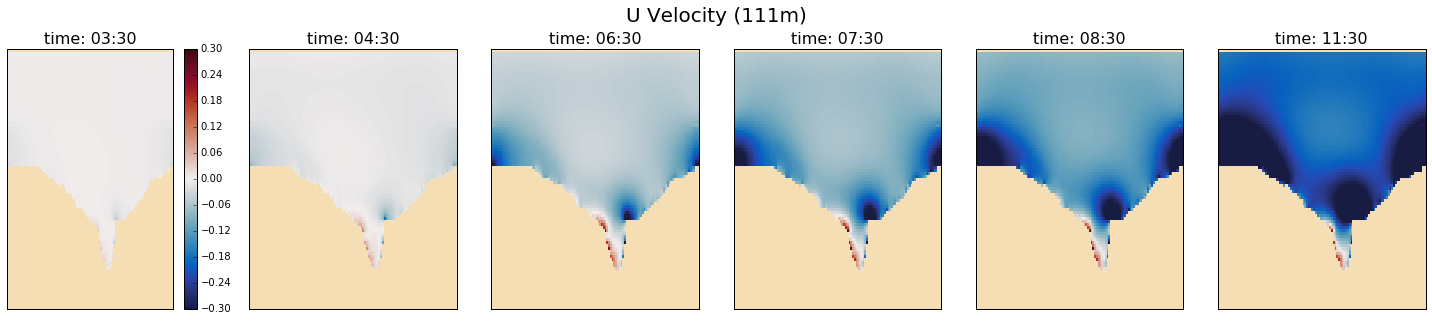

In [7]:
dep = 8
time_inds = [3,4,6,7,8,11]
bd = 0.3
max_min = True
supttl = 'U Velocity'
fig = plot_gyre_times(gridT_I2, U_I2, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)
fig = plot_gyre_times(gridT_R2, U_R2, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)

# Run03, 04, and 05: Lateral Boundary Conditions

These runs also use **ideal_bathy_01.nc**, **real_bathy_01.nc**, **coords_01.nc**, **temp_strat.nc**, and **salt_strat.nc**. For brevity, I only ran the idealized bathymetry to test the slip conditions.

### Notes
(Page 154 to 157, diagram in page 156) In namlbc:

| Parameter             | Description | Run01 (Id & Re)| Run02 (Id & Re)| Run03 (Id)| Run04 (Id)| Run05 (Id)|
|-----------------------|------------------------------------------------------------------------|---|---|-----|-----|
|rn_shlat|**free slip** = 0, 0 < **partial slip** < 2, **no slip** = 2, **strong slip** > 2| 0 | 0 | 0.25 | 0.5 | 2.0 |

The [Salish Sea Green Model Configurations](http://salishsea-meopar-docs.readthedocs.io/en/latest/results_server/nowcast-green.html) show an adjustment of rn_shlat to 0.5. The [Salish Sea Lateral Dynamics Notes](http://salishsea-meopar-docs.readthedocs.io/en/latest/turbulence/lateral_viscosity.html) show that the lateral eddy viscosity and choice of slip conditions go hand in hand. You want some slip to resolve the boundary layer, especially at lower viscosities.

In [12]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run03'
gridT_I3, lon_I3, lat_I3, tem_I3, sal_I3, ssh_I3, U_I3, V_I3, W_I3 = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run04'
gridT_I4, lon_I4, lat_I4, tem_I4, sal_I4, ssh_I4, U_I4, V_I4, W_I4 = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run05'
gridT_I5, lon_I5, lat_I5, tem_I5, sal_I5, ssh_I5, U_I5, V_I5, W_I5 = functions_plot.load_model_output(path, cfg)

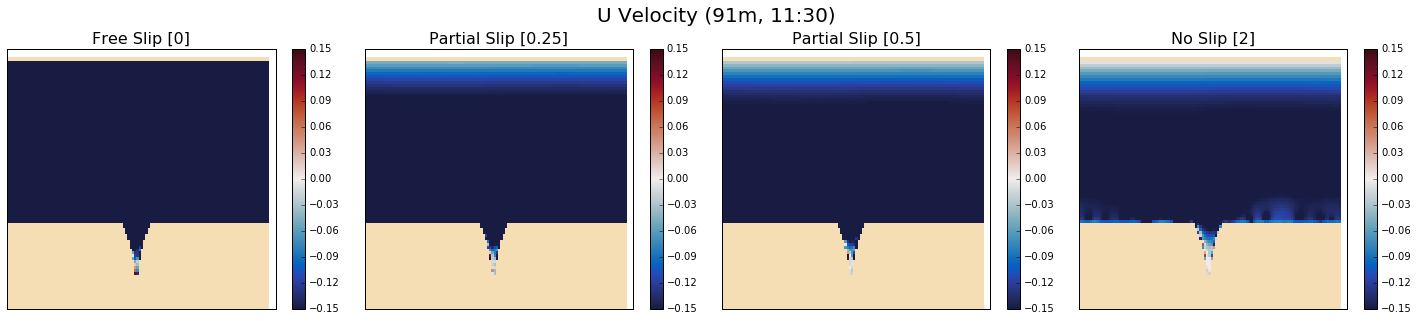

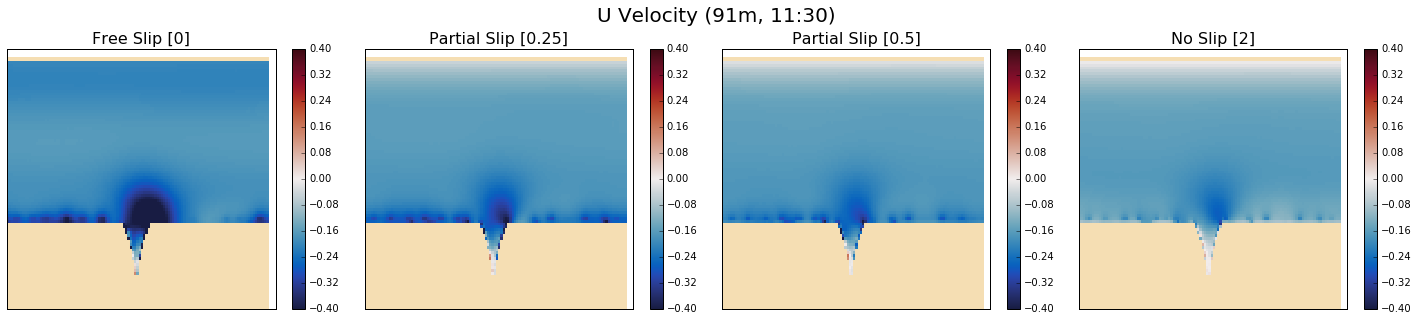

In [20]:
all_vars = [U_I2, U_I3, U_I4, U_I5]
depth_ind = 7
time_ind = 11
bd = [0.15]*4
max_min = True
supttl = 'U Velocity'
ttls = ['Free Slip [0]', 'Partial Slip [0.25]', 'Partial Slip [0.5]', 'No Slip [2]']
fig =  plot_vars(gridT_I2, all_vars, depth_ind, time_ind, bd, cmo.cm.balance, max_min, supttl, ttls)

bd = [0.4]*4
fig =  plot_vars(gridT_I2, all_vars, depth_ind, time_ind, bd, cmo.cm.balance, max_min, supttl, ttls)

# Run 06 and 07: Diffusivity and Viscosity 

These runs also use **ideal_bathy_01.nc**, **real_bathy_01.nc**, **coords_01.nc**, **temp_strat.nc**, and **salt_strat.nc**.

### Notes
(Page 178) Laterial diffiusion is set through nameslist parameters in namdyn_ldf (lateral diffusion on momentum) and namtra_ldf (lateral diffusion scheme for tracers) and CPP keys:

| Parameter     |Subroutine|Description| Run04(Id)|Run06(Id)|Run07t(Id)|Run07(Id)|Run08(Id)|Run09(Id)|
|---------------|----------|-----------|----------|---------|---------|---------|
|rn_shlat       |          |slip condition                        |0.5   |0.5|0.5|0.5|0.5|0.5|
|||**Horizontal Tracer Diffusion**|||||||
|ln_traldf_lap  |namtra|laplacian operator (tracer)               |true  |---|---|---|---||
|ln_traldf_bilap|namtra|bilaplacian operator                      |false |---|---|---|---||
|rn_aeiv_0      |namtra|eddy induced velocity coefficient [m2/s]  |0     |0  |2000|50 |50 |50|
|||**Horizontal Dynamics Viscosity**|||||||
|ln_dynldf_lap  |namdyn|laplacian operator (dynamic)              |true  |---|---|---|---||
|ln_dynldf_bilap|namdyn|bilaplacian operator                      |false |---|---|---|---||
|rn_ahm_0_lap   |namdyn|horizontal laplacian eddy viscosity [m2/s]|100000|50 |100000|100000|50|150|


[pg 179] Six CPP keys control the space variation of eddy coefficients: key traldf c3d, key dynldf c3d, key traldf c2d, key dynldf c2d, key traldf c1d, key dynldf c1d. When none of the keys are defined (default), a constant value is used over the whole ocean for momentum and tracers, which is specified through the rn_ahm0 and rn_aht0 namelist parameters.

### Viscosity and Slip
No traldf or dynldf keys defined for constant viscosity.

[Salish Sea Docs](http://salishsea-meopar-docs.readthedocs.io/en/latest/turbulence/lateral_viscosity.html) 
* no slip shows stabilizing features
  * unresolved boundary layer, especially at low viscosities (rn_ahm_0_lap)

[Lab-Numerical Model Comparisons, Boyer et al (2003)](http://journals.ametsoc.org/doi/pdf/10.1175/1520-0485%282004%29034%3C1588%3ALMCOCF%3E2.0.CO%3B2) 
* no slip condition along the floor improves the model away from the canyon boundaries
  * but needs enhanced viscocities for stability
  * boundary layers too wide along the coastline
* vertical and horizontal viscosities were 1 and 100 times the kinematic viscosity
* the kinematic viscosity of water is ~ 1e-6 m2/s = 0.01 cm2/s [pg 1590]. 100 times this is 1 cm2/s = 1e-4 m2/s [pg 1593] 
* [pg 1594] "It is concluded that the use of enhanced eddy viscosities, as evidenced in the present experiments, must be done with caution because such viscosities can affect the basic flow patterns."
* pros of no slip: capturing symmetry across the canyon axis of lab experiments, predicting maximum of vorticity and horizontal divergence, and representing anticyclonic patter in upper left side of canyon
* cons of no slip: thick boundary layer of anticyclonic vorticity along canyon walls due to enhanced horizontal viscosity
* [sister paper](http://journals.ametsoc.org/doi/pdf/10.1175/1520-0426%282001%29018%3C1699%3AISFIAS%3E2.0.CO%3B2)

### Diffusivity
    ! Value rn_aeiv_0 is ignored unless = 0 with Held-Larichev spatially varying aeiv
    ! (key_traldf_c2d & key_traldf_eiv & key_orca_r2, _r1 or _r05)

[CONFIG/AMM12/EXP00](http://forge.ipsl.jussieu.fr/little_nemo/changeset/7/trunk/NEMOGCM/CONFIG/AMM12/EXP00) and [Dussin et al (2012)](https://www.drakkar-ocean.eu/publications/reports/orca025-grd100-report-dussin)

    rn_aeiv_0        =    0.     !     eddy induced velocity coefficient [m2/s]    (require "key_traldf_eiv") 
    (normally=0; not used with Griffies) 

[Hewitt et al (2010)](http://geosci-model-dev.net/4/223/2011/gmd-4-223-2011.pdf) pg 246 has a list of cpp keys and the [Supplementary Material](http://www.geosci-model-dev.net/4/223/2011/gmd-4-223-2011-supplement.pdf) shows aeiv0 as 1000 and references key_traldf_eiv: Eddy-induced (Gent-McWilliams) advection activated
    
[Vidard et al (2014) NemoTam Manual](https://hal.archives-ouvertes.fr/hal-00941626/document) and [Cerfacs definition](http://www.cerfacs.fr/~maisonna/Dynamite/nemo.html): Tracer lateral diffusion eddy induced velocity parameterization

[Vichi et al (2015)](http://bfm-community.eu/publications/bfmnemomanual_r1.0_201508.pdf): Eddy-induced velocity parameterization of enhanced diffusion
 
The [Salish Sea Model](https://salishsea.eos.ubc.ca/_static/nemo/model_evaluation_summary.pdf) shows that the model uses a horizontal diffusivity and viscosity of 2m$^2$s$^{-1}$ for a resolution of 500 m. My resolution is 4000 m.


### Read
[Flow Dynamics of a Wide Arctic Canyon, Signorini et al (1997)](http://onlinelibrary.wiley.com/store/10.1029/97JC00739/asset/jgrc7033.pdf?v=1&t=iwnv6gj0&s=f78f4102102c1570459c4381de296db545d710b4&systemMessage=Wiley+Online+Library+will+be+unavailable+on+Saturday+17th+December+2016+at+09%3A00+GMT%2F+04%3A00+EST%2F+17%3A00+SGT+for+4hrs+due+to+essential+maintenance.Apologies+for+the+inconvenience)

[Oceanography of the Canadian Shelf of the Beaufort Sea: A Setting for Marine Life, Carmack and Macdonald (2001)](http://pubs.aina.ucalgary.ca/arctic/Arctic55-S-29.pdf)


[laplacian diffusion vs resolution](http://onlinelibrary.wiley.com/store/10.1029/2005GL022514/asset/grl19622.pdf;jsessionid=292AF90A1C0E628E05C2E00B8D10C303.f01t02?v=1&t=iwncows9&s=94564986d7704633772a2a9bae2e7a82e740ceb2&systemMessage=Wiley+Online+Library+will+be+unavailable+on+Saturday+17th+December+2016+at+09%3A00+GMT%2F+04%3A00+EST%2F+17%3A00+SGT+for+4hrs+due+to+essential+maintenance.Apologies+for+the+inconvenience)




undercurrent comes with ANHA?


In [31]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run06'
gridT_I6, lon_I6, lat_I6, tem_I6, sal_I6, ssh_I6, U_I6, V_I6, W_I6 = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run07_test'
gridT_I7t, lon_I7t, lat_I7t, tem_I7t, sal_I7t, ssh_I7t, U_I7t, V_I7t, W_I7t = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run07'
gridT_I7, lon_I7, lat_I7, tem_I7, sal_I7, ssh_I7, U_I7, V_I7, W_I7 = functions_plot.load_model_output(path, cfg)

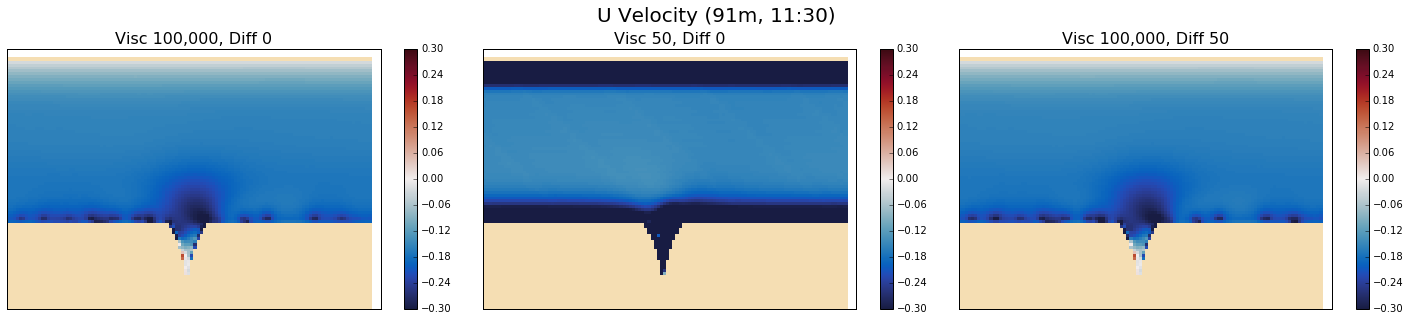

In [36]:
all_vars = [U_I4, U_I6, U_I7]
depth_ind = 7
time_ind = 11
bd = [0.3]*3
max_min = True
supttl = 'U Velocity'
ttls = ['Visc 100,000, Diff 0', 'Visc 50, Diff 0', 'Visc 100,000, Diff 50']
fig =  plot_vars(gridT_I4, all_vars, depth_ind, time_ind, bd, cmo.cm.balance, max_min, supttl, ttls)

In [13]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run08'
gridT_I8, lon_I8, lat_I8, tem_I8, sal_I8, ssh_I8, U_I8, V_I8, W_I8 = functions_plot.load_model_output(path, cfg)

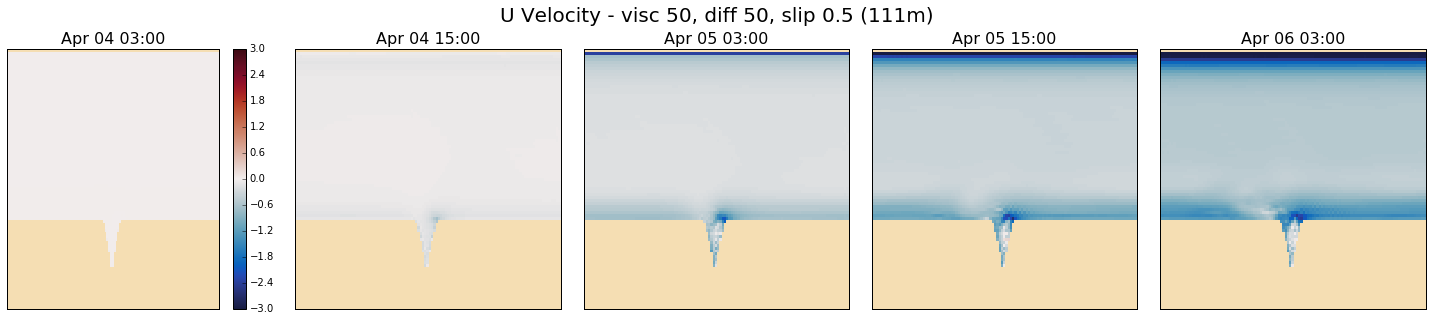

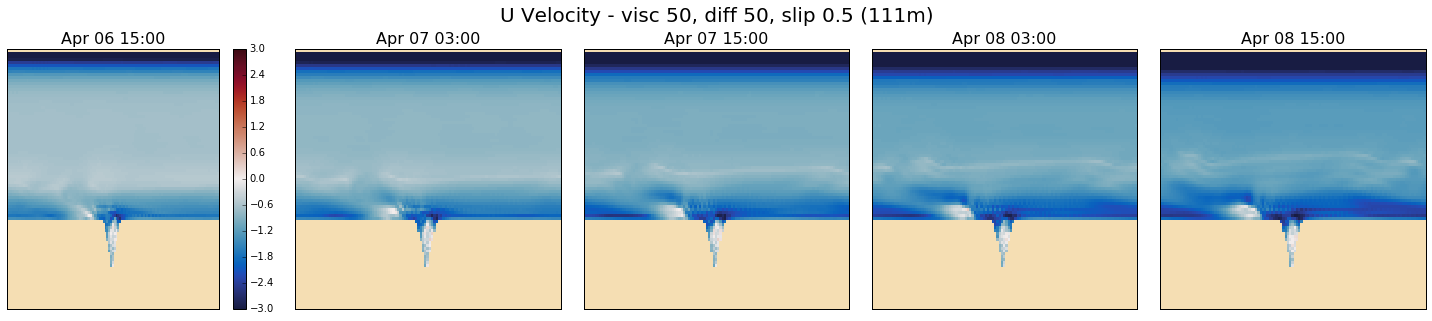

In [49]:
dep = 8 
bd = 3.0
max_min = True
supttl = 'U Velocity - visc 50, diff 50, slip 0.5'
time_inds = [0,2,4,6,8]
fig = plot_gyre_times(gridT_I8, U_I8, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)
time_inds = [10,12,14,16,18]
fig = plot_gyre_times(gridT_I8, U_I8, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)

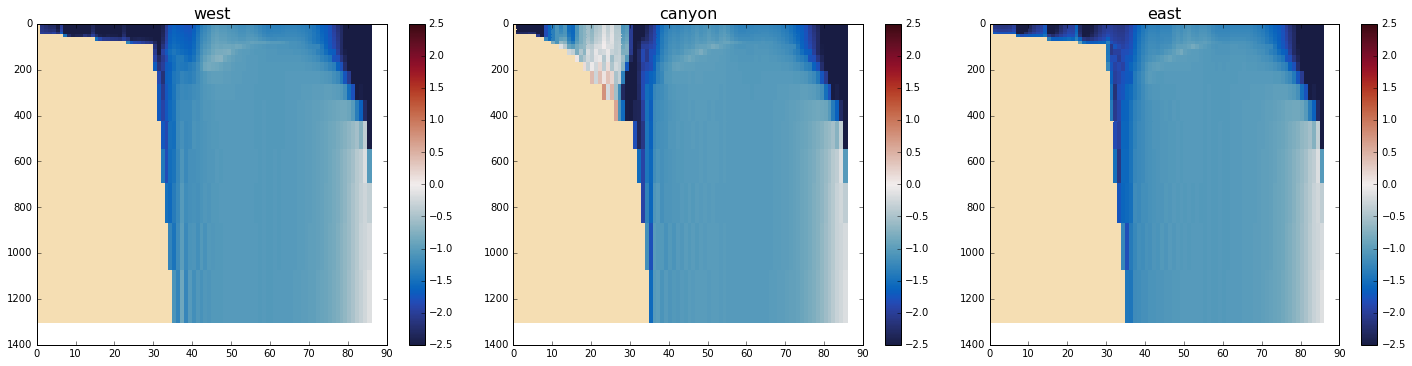

In [109]:
depth8 = gridT_I8['deptht'][:]
ys = np.arange(87)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5)); plt.tight_layout()
for x_ind, ax, ttl in zip([20,58,80], [ax1, ax2, ax3], ['west', 'canyon', 'east']):
    c = ax.pcolormesh(ys,depth8,U_I8[16,:,:,x_ind], cmap=cmo.cm.balance, vmin = -2.5, vmax = 2.5)
    fig.colorbar(c, ax=ax); ax.invert_yaxis(); ax.set_title(ttl, fontsize=16)

# Open Boundaries

[Page 163 to 165]

* obc_oce.F90
  * NEMOGCM/NEMO/OPA_SRC/OBC
  * Open Boundary Conditions: define related variables
  * **nbobc** is the number of open boundaries ( 1=< nbobc =< 4 )
  * other variables in the module include ln_obc_clim and rn_volemp, which are in namobc in namelist_ref, but nbobc is in a different section in obc_oce labelled "OLD non-DOCTOR name of namelist variables" and it is not in namelist_ref
  * <font color='DodgerBlue'>Where do I change nbobc value to 3? or 1 (if I have periodic conditions through jperio)?</font> 
  * [obc_oce.F90 code](http://forge.ipsl.jussieu.fr/little_nemo/browser/trunk/NEMOGCM/NEMO/OPA_SRC/OBC/obc_oce.F90), [Wiki instructions](https://source.ggy.bris.ac.uk/wiki/Nemo)
  
  
* obc_par.F90: 
  * NEMOGCM/NEMO/OPA_SRC/OBC
  * Open Boundary Conditions: define related parameters
  * **lp_obc_north** = .FALSE.   !: to active or not the North open boundary
  * <font color='DodgerBlue'>Set logical parameter to TRUE for north. Test if you need it for west and east even if you have periodic conditions still (jperio).</font>
  * [obc_par.F90 code](http://forge.ipsl.jussieu.fr/little_nemo/browser/trunk/NEMOGCM/NEMO/OPA_SRC/OBC/obc_par.F90), [Wiki instructions](https://source.ggy.bris.ac.uk/wiki/Nemo)


* obc_par.F90
  * constant index **jpjnob** <= jpjglo-2
  * starting index **jpind** >= 2
  * ending index **jpinf** <= jpiglo-1
  * <font color='DodgerBlue'>Check that jpjnob is the max. Check that jpind/f are at the farthest out.</font>
  * [Page 164] There still must be a row of masked points all around the domain, as if the domain were a closed basin (unless periodic conditions are used together with open boundary conditions). <font color='DodgerBlue'> So, does that mean that I'll be able to remove the northern wall *only* because I'm using period conditions?</font>
  
  
* namelist_ref
  * namobc **nn_obcdta** = 0 the obc data are equal to the initial state (information does not change in time and is equal to the initial conditions). If it = 1, open boundary information is read from netcdf files (obc.dta).
  * [Page 67] The "initial state" is **sn_tem**, **sn_sal**, and **cn_dir** in namtsd. This part has been covered when including the Arctic stratification (above). <font color='DodgerBlue'>Does it need velocity?</font>


* "key_obc" (Open Boundary Condition)
  * *key key_obc is not found in gyre_mackenzie02/WORK routine*


# Boundary Conditions

NEMO 3.4 had an OBC module (Open Boundary Conditions - key_obc), but NEMO 3.6 rewrote it as the BDY (Unstructured Open Boundary Conditions - key_bdy) module.


|Parameter|Description (nambdy, namelist_cfg, "key_bdy")|Run08(Id)|Run09(Id)|
|---------|-----------|---------|
|nb_bdy         |number of open bdy sets|0|1|
|ln_coords_file |read from file (or define in namelist)|true|false|
|cn_dyn2d       |BC for barotropic variables (U, V, SSH)|none|flather|
|nn_dyn2d_dta   |use the initial state as bdy dta (or from file)|0|0|
|cn_dyn3d       |BC for baroclinic velocities|none|orlanski|
|nn_dyn3d_dta   |use the initial state as bdy dta (or from file)|0|0|
|cn_tra         |BC for active tracers (T and S)|none|neumann|
|nn_tra_dta     |use the initial state as bdy dta (or from file)|0|0|
|ln_tra_dmp     |tracer damping (open BC for tracers)|false|false|
|ln_dyn3d_dmp   |baroclinic velocity damping (open BC for vels)|false|false|
|rn_time_dmp    |damping time scale (days)|1|1|
|rn_time_dmp_out|damping time scale (days) at radiation outflow points|1|1|
|nn_rimwidth    |boundary rim width for Flow Relaxation Scheme|10|10|


|Parameter|nambdy_index           |1        |2        |3        |
|--------|------------------------|---------|---------|---------|
|ctypebdy|N, S, E or W            |'N'      |'W'      |'E'      |
|nbdyind |constant index (y, x, x)|87-2=85  |2        |117-2=115|
|nbdybeg |starting index (x, y, y)|2        |2        |2        |
|nbdyend |ending index (x, y, y)  |117-1=116|87-1=86  |87-1=86  |


* [Question for nemo about BDY namelist](http://www.nemo-ocean.eu/Developing-with-NEMO/Forum/BDY-namelist-in-NEMO-3.6)
* [SS-run-sets / SalishSea / nemo3.6 / namelist.lateral](https://bitbucket.org/salishsea/ss-run-sets/src/bc2cc3188a7e09e310c0a499e989022926be89e8/SalishSea/nemo3.6/namelist.lateral?at=default&fileviewer=file-view-default)
* [Understanding the AMM12 Namelist](http://salishsea-meopar-docs.readthedocs.io/en/latest/code-notes/dev-notes/AMM12_namelist.html)
* [NEMO 3.6 Bugs and Quirks](http://salishsea-meopar-docs.readthedocs.io/en/latest/code-notes/dev-notes/nemo_3-6_quirks.html)
* [Nemo report on free surface](http://www.nemo-ocean.eu/About-NEMO/Reference-manuals)

(<matplotlib.colorbar.Colorbar at 0x7f4bb77c64a8>,
 <matplotlib.colorbar.Colorbar at 0x7f4bb77a4be0>)

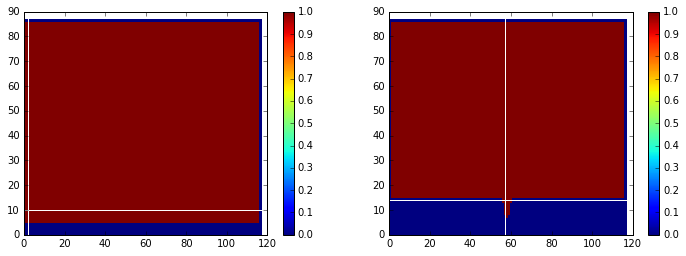

In [89]:
tmask = nc.Dataset('/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/gyre_mackenzie02/EXP00/mesh_mask.nc')['tmask'][0,:,:,:]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
c1 = ax1.pcolormesh(tmask[0,:,:])
c2 = ax2.pcolormesh(tmask[3,:,:])
ax2.axhline(14, color='white')
ax1.axhline(10, color='white'); ax1.axvline(2, color='white')
fig.colorbar(c1, ax=ax1), fig.colorbar(c2, ax=ax2)

In [11]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run09_test'
gridT_I9t, lon_I9t, lat_I9t, tem_I9t, sal_I9t, ssh_I9t, U_I9t, V_I9t, W_I9t = functions_plot.load_model_output(path, cfg)

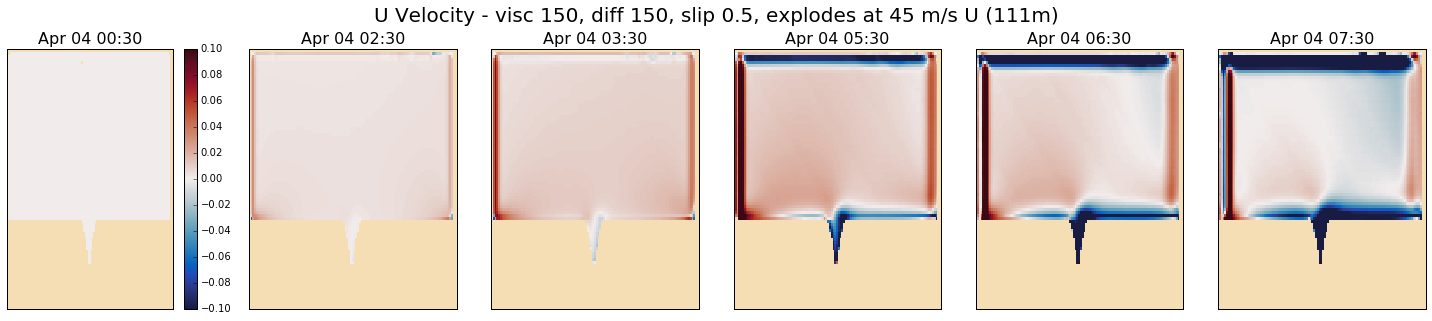

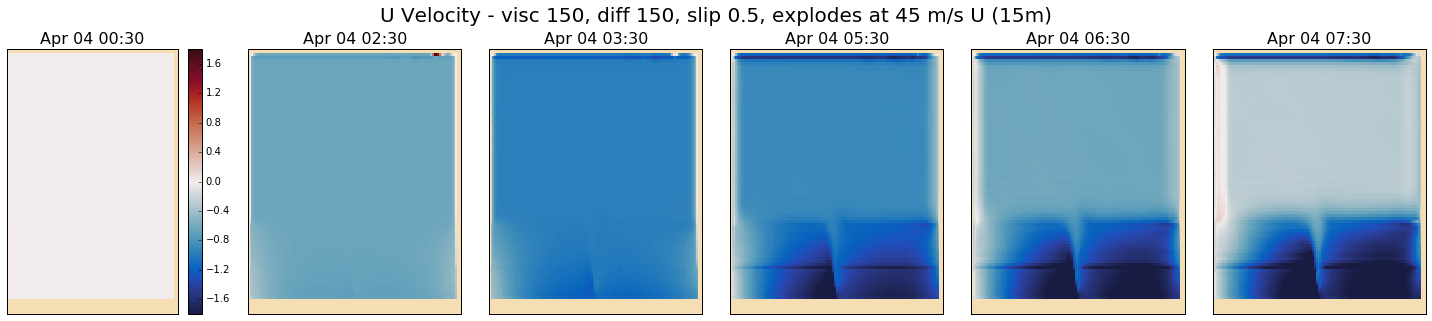

In [110]:
dep = 8
bd = 0.1
max_min = True
supttl = 'U Velocity - visc 150, diff 150, slip 0.5, explodes at 45 m/s U'
time_inds = [0,2,3,5,6,7]
fig = plot_gyre_times(gridT_I9t, U_I9t, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)
dep = 1
bd = 1.8
max_min = True
fig = plot_gyre_times(gridT_I9t, U_I9t, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)

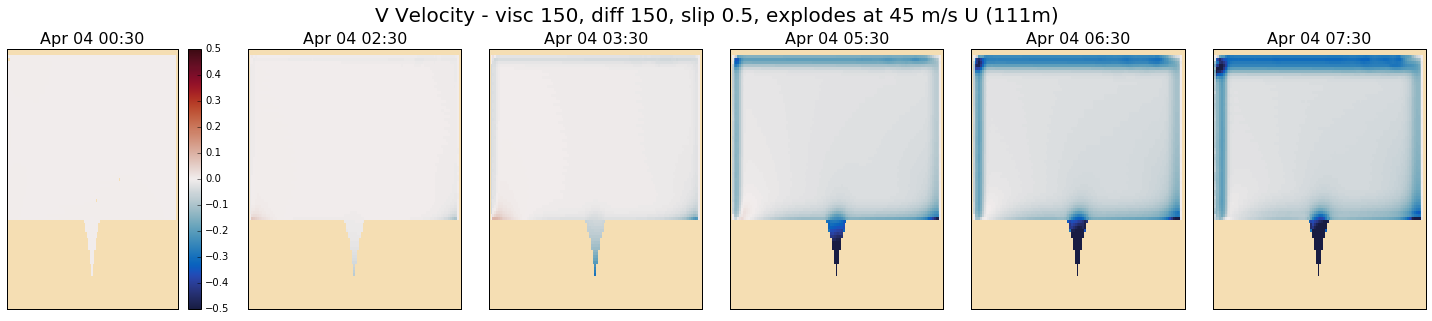

In [111]:
dep = 8
bd = 0.5
max_min = True
supttl = 'V Velocity - visc 150, diff 150, slip 0.5, explodes at 45 m/s U'
time_inds = [0,2,3,5,6,7]
fig = plot_gyre_times(gridT_I9t, V_I9t, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)

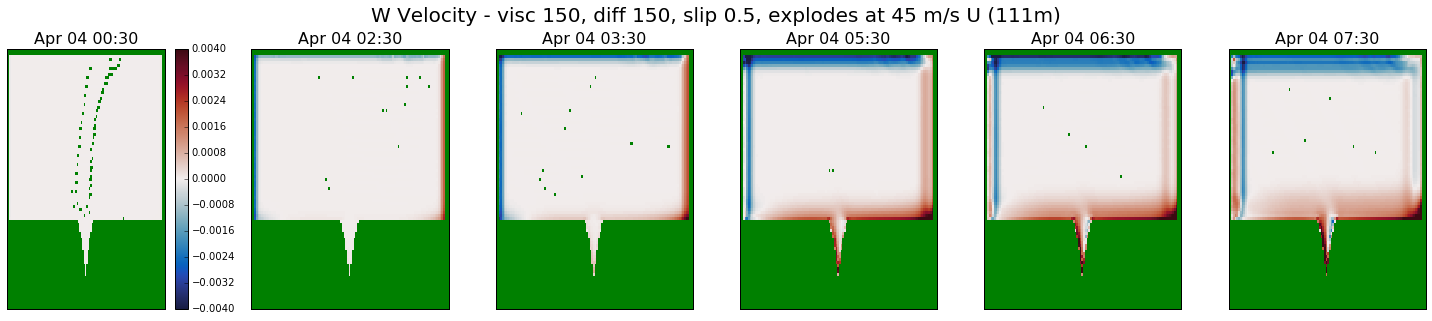

In [114]:
dep = 8
bd = 0.004
max_min = True
supttl = 'W Velocity - visc 150, diff 150, slip 0.5, explodes at 45 m/s U'
time_inds = [0,2,3,5,6,7]
fig = plot_gyre_times(gridT_I9t, W_I9t, dep, time_inds, bd, cmo.cm.balance, max_min, supttl)